# Telco Classification Project

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
pd.set_option('display.max_colwidth', 200)
import seaborn as sns
from scipy import stats
import acquire as a
import prepare as p
import explore as e
import model as m
import os
import env
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression #logistic not linear!
from sklearn.neighbors import KNeighborsClassifier #pick the classifier one
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Acquire

* Data acquired from the Codeup MySQL database `telco_churn`
* Size is 7,043 rows and 24 columns before preparing.
* Each row represents a customer at Telco
* Each column represents a feature of the customers.

In [2]:
# Import acquired messy data from your acquire file here
def get_telco_data():
    '''
    Retrieves the telco dataframe. The MySQL query will return all columns from the customers table,
    with the three additional columns because of the joins using their ids.
    The check file function will assure the telco file exists and what to do if it doesn't.
    '''
    url = env.get_db_url('telco_churn')
    query = '''
    select *
    from customers
        join contract_types
            using (contract_type_id)
        join internet_service_types
            using (internet_service_type_id)
        join payment_types
            using (payment_type_id)
    '''
    
    filename = 'telco_churn.csv'

    #call the check_file_exists fuction 
    df = check_file_exists(filename, query, url)
    return df

In [3]:
df = a.get_telco_data()

this file exists, reading csv


In [4]:
df.shape

(7043, 24)

## Prepare

* Drop duplicate columns that are unnecesary
    * `payment_type_id`
    * `internet_service_type_id`
    * `contract_type_id`
* Replaced empty space values with 0.0 to assign it a value
* Filled null values with 'No internet service' because that's what it was originally supposed to represent, they weren't really null.

In [5]:
df = p.prep_telco(df)

In [6]:
df.shape

(7043, 21)

In [7]:
df.internet_service_type.value_counts()

internet_service_type
Fiber optic            3096
DSL                    2421
No internet service    1526
Name: count, dtype: int64

In [8]:
# Splitting the DataFrame 'df' into training, validation, and test sets using the 'churn' column for stratification
# The resulting subsets are assigned to variables 'train', 'validate', and 'test'

train, validate, test = p.splitting_data(df, 'churn')

In [9]:
print(train.shape)
print(validate.shape)
test.shape

(4225, 21)
(1409, 21)


(1409, 21)

In [10]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,No internet service,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* How often are customers churning
* Is churn independent of tech support?
* Is churn independent of internet service type?
* Is churn independent of phone service?
* Are there variations in churn based on monthly charges?
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

**The following empty code block** is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, visualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approaches to your data such as using pair plots to look at the relationships of each feature 
are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing and supporting your findings, not showing the work you did to get there!**

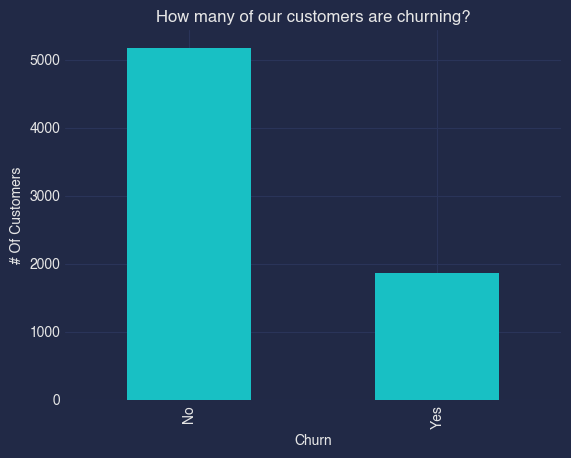

27.0


In [11]:
df.churn.value_counts().plot.bar()
plt.title('How many of our customers are churning?')
plt.xlabel('Churn')
plt.ylabel('# Of Customers')
plt.show()
print(round((df.churn == 'Yes').sum() / len(df),2)*100)

In [12]:
# Total Churn Rate
df['churn'].value_counts(normalize=True)

churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [13]:
# Support Churn Rate
support = df[df['tech_support'] == 'No']
support['churn'].value_counts(normalize=True)

churn
No     0.583645
Yes    0.416355
Name: proportion, dtype: float64

In [14]:
# Fiber Churn Rate
fiber = df[df['internet_service_type'] == 'Fiber optic']
fiber['churn'].value_counts(normalize=True)

churn
No     0.581072
Yes    0.418928
Name: proportion, dtype: float64

### Calculate the average value for tech_support == 'No' and 'Yes'

In [16]:
# monthly COST
fiber[fiber['tech_support'] == 'No']['monthly_charges'].mean()

87.7427802690583

In [17]:
# bit pricier to have tech support but worth it!
fiber[fiber['tech_support'] == 'Yes']['monthly_charges'].mean()

101.17551963048498

In [21]:
# churn rate in fiber optic customers WITHOUT tech_support
no_tech_support_df = fiber[fiber['tech_support'] == 'No']
no_tech_support_churn_rate = no_tech_support_df['churn'].value_counts(normalize=True)['Yes']
no_tech_support_churn_rate

0.49372197309417043

In [22]:
# churn rate in fiber optic customers WITH tech_support
tech_support_df = fiber[fiber['tech_support'] == 'Yes']
tech_support_churn_rate = tech_support_df['churn'].value_counts(normalize=True)['Yes']
tech_support_churn_rate

0.22632794457274827

## Potention retention increase if fiber optic customers WITHOUT tech support GET tech support is:

# 26.74%

In [23]:
no_tech_support_churn_rate - tech_support_churn_rate

0.26739402852142213

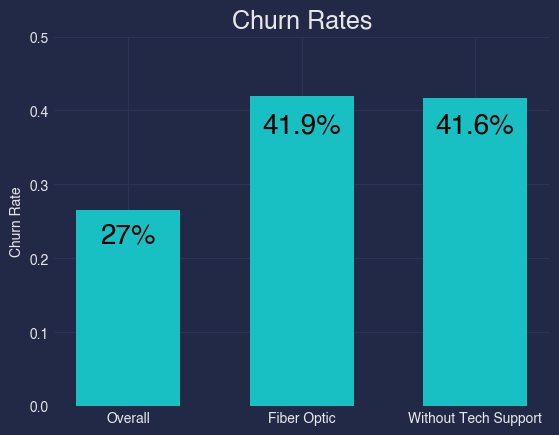

In [26]:
import matplotlib.pyplot as plt

# Calculate the total number of customers in each dataframe
total_telco = len(df)
total_fiber = len(fiber)
total_support = len(support)

# Calculate the number of customers who churned in each dataframe
telco_churned = df[df['churn'] == 'Yes']
fiber_churned = fiber[fiber['churn'] == 'Yes']
support_churned = support[support['churn'] == 'Yes']

# Calculate the churn rate for each dataframe
telco_churn_rate = len(telco_churned) / total_telco
fiber_churn_rate = len(fiber_churned) / total_fiber
support_churn_rate = len(support_churned) / total_support

# Create a grouped bar plot of the churn rates
bar_width = 0.6  # Increase the width of the bars
plt.bar([0, 1, 2], [telco_churn_rate, fiber_churn_rate, support_churn_rate], width=bar_width, label='Churn Rate')
plt.xticks([0, 1, 2], ['Overall', 'Fiber Optic', 'Without Tech Support'])
plt.title('Churn Rates', fontsize=18)
plt.ylabel('Churn Rate')
plt.ylim(0, 0.5)

# Add text to the first column of the plot
plt.text(0, 0.23, f'{telco_churn_rate:.0%}', ha='center', va='center', fontsize=20, color='black')

# Add text to the second column of the plot
plt.text(1, 0.38, f'{fiber_churn_rate:.1%}', ha='center', va='center', fontsize=20, color='black')

# Add text to the third column of the plot
plt.text(2, 0.38, f'{support_churn_rate:.1%}', ha='center', va='center', fontsize=20, color='black')

# Show the plot
plt.show()

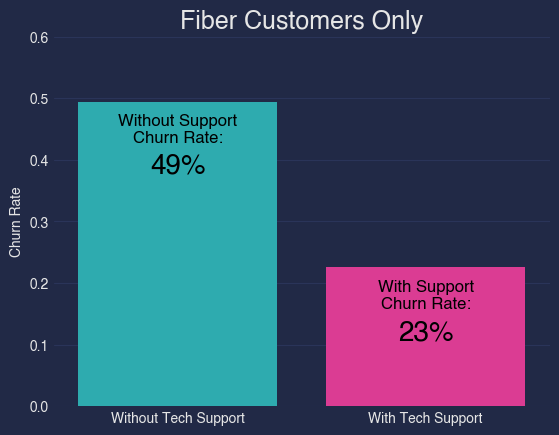

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot of the churn rates
sns.barplot(x=['Without Tech Support', 'With Tech Support'], y=[no_tech_support_churn_rate, tech_support_churn_rate])
plt.title('Fiber Customers Only', fontsize=18)
plt.ylabel('Churn Rate')
plt.ylim(0, 0.6)

# Calculate the churn rate in people without tech_support
no_tech_support_df = fiber[fiber['tech_support'] == 'No']
no_tech_support_churn_rate = no_tech_support_df['churn'].value_counts(normalize=True)['Yes']

# Calculate the churn rate in people with tech_support
tech_support_df = fiber[fiber['tech_support'] == 'Yes']
tech_support_churn_rate = tech_support_df['churn'].value_counts(normalize=True)['Yes']

# Add text to the first column of the plot
plt.text(0, 0.45, f'Without Support\nChurn Rate:', ha='center', va='center', fontsize=12, color='black')
plt.text(0, 0.39, f'{no_tech_support_churn_rate:.0%}', ha='center', va='center', fontsize=20, color='black')

# Add text to the second column of the plot
plt.text(1, 0.18, f'With Support\nChurn Rate:', ha='center', va='center', fontsize=12, color='black')
plt.text(1, 0.12, f'{tech_support_churn_rate:.0%}', ha='center', va='center', fontsize=20, color='black')

# Show the plot
plt.show()

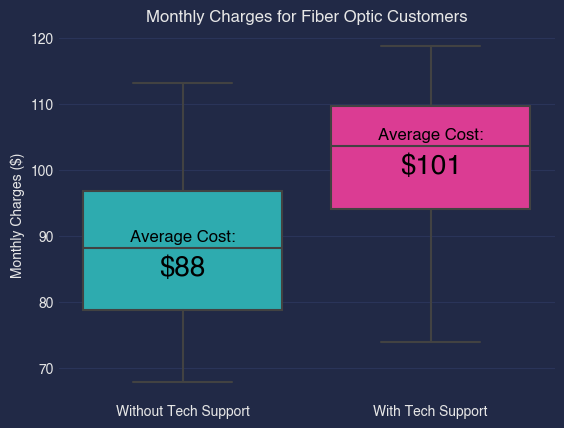

In [35]:
import seaborn as sns
from scipy import stats

# # Calculate the average monthly charges
# average = fiber['monthly_charges'].mean()

# Create a boxen plot with the tech_support variable on the x-axis and the monthly cost on the y-axis
sns.boxplot(data=fiber, x='tech_support', y='monthly_charges')

# Add a title to the plot with the name of the quantitative variable
plt.title('Monthly Charges for Fiber Optic Customers')

# # Add a horizontal line to the plot at the average value of the quantitative variable
# plt.axhline(average, ls="--")

# Change the x-axis labels
plt.xticks([0, 1], ['Without Tech Support', 'With Tech Support'])
plt.xlabel('')

# Change the y-axis label
plt.ylabel('Monthly Charges ($)')

# Average cost
avg_no_tech_support = fiber[fiber['tech_support'] == 'No']['monthly_charges'].mean()
avg_yes_tech_support = fiber[fiber['tech_support'] == 'Yes']['monthly_charges'].mean()

# Add text to the first column of the plot
plt.text(0, 88.5, f'Average Cost:\n', ha='center', va='center', fontsize=12, color='black')
plt.text(0, 85, f'${avg_no_tech_support:.0f}', ha='center', va='center', fontsize=20, color='black')

# Add text to the second column of the plot
plt.text(1, 104, f'Average Cost:\n', ha='center', va='center', fontsize=12, color='black')
plt.text(1, 100.5, f'${avg_yes_tech_support:.0f}', ha='center', va='center', fontsize=20, color='black')

# Show the plot
plt.show()

### **Statistical Hypothesis Testing**

tech_support & churn

Chi2: 482.09154879788
P-value: 6.05233167722674e-101
Degrees of Freedom: 6


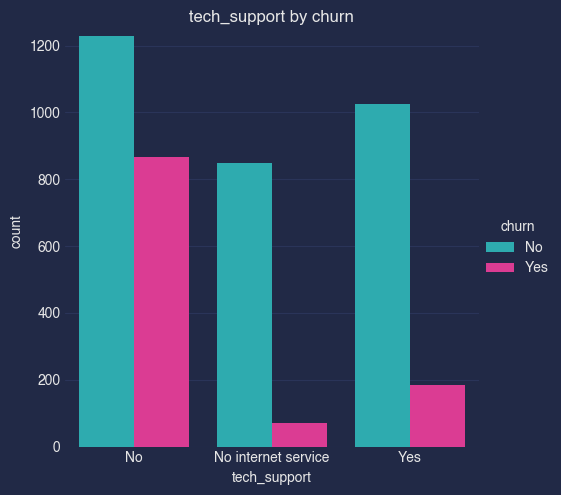

In [12]:
# Use explore_categorical using train data to run Chi2 and plot
e.explore_categorical(train, 'churn', 'tech_support')

### **1. <i>Is `churn` independent of `tech_support`?</i>**
<i> discrete (`churn`) vs Discrete (`tech_support`) = $Chi^2$ </i>

* $H_0$: `churn` is independent from `tech_support`

* $H_a$: `churn` is **NOT** independent from `tech_support`

* α = 0.05

    - $Chi^2$ = 482.09154879788
    - $p$ = 6.05233167722674e-101
    - $p$  <  α

### <b> <u> We reject the null hypothesis. </u> </b>

internet_service_type & churn

Chi2: 417.88813854093104
P-value: 3.9804371258943206e-87
Degrees of Freedom: 6


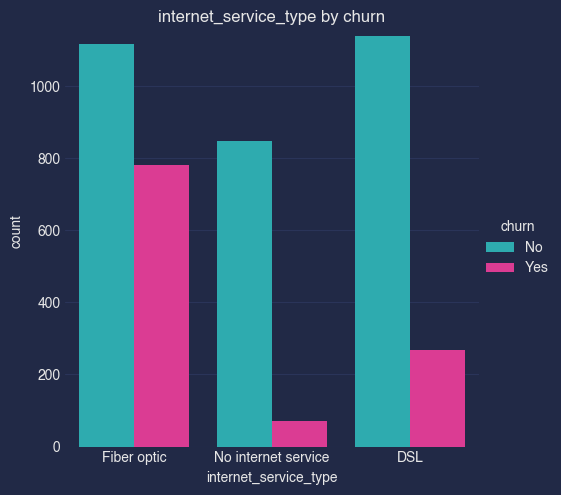

In [13]:
# Use explore_categorical using train data to run Chi2 and plot
e.explore_categorical(train, 'churn', 'internet_service_type')

### **2. <i>Is there a difference in `churn` based on `internet_service_type`?</i>**
<i> Discrete (`churn`) vs Discrete (`internet_service_type`) = $Chi^2$ </i>

* $H_0$: `churn` is independent from `internet_service_type`

* $H_a$: `churn` is **NOT** independent from `internet_service_type`

* α = 0.05

    - $Chi^2$ = 417.88813854093104
    - $p$ = 3.9804371258943206e-87
    - $p$  <  α

### <b> <u> We reject the null hypothesis. </u> </b>

phone_service & churn

Chi2: 0.4404388389725981
P-value: 0.9790341790305054
Degrees of Freedom: 4


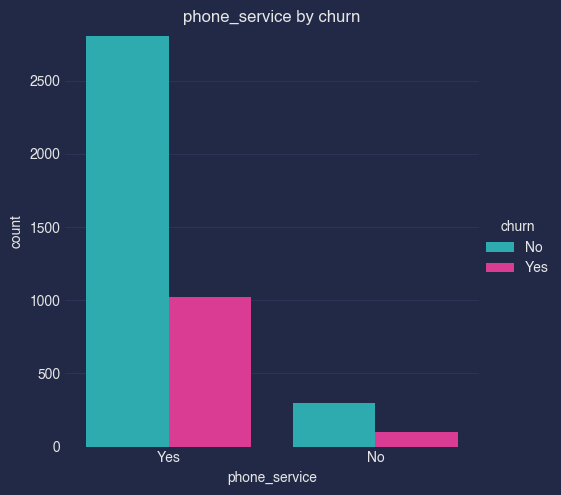

In [14]:
# Use explore_categorical using train data to run Chi2 and plot
e.explore_categorical(train, 'churn', 'phone_service')

### **3. <i>Is `churn` independent of `phone_service`?</i>**
<i> discrete (`churn`) vs Discrete (`phone_service`) = $Chi^2$ </i>

* $H_0$: `churn` is independent from `phone_service`

* $H_a$: `churn` is **NOT** independent from `phone_service`

* α = 0.05

    - $Chi^2$ = 0.4404388389725981
    - $p$ = 0.9790341790305054
    - $p$  >  α

### <b> <u> We fail to reject the null hypothesis. </u> </b>

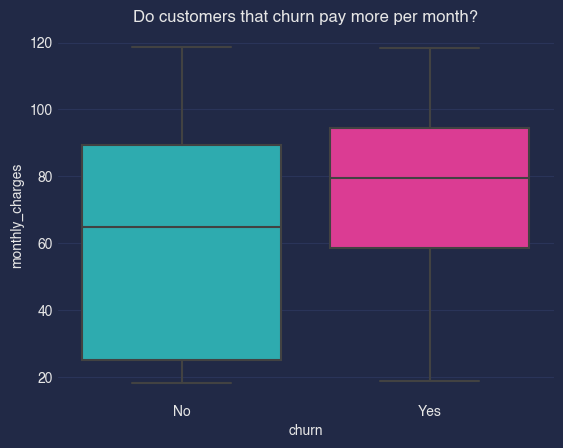

In [15]:
#Monthly charges and churn
sns.boxplot(data=train, y='monthly_charges', x='churn')
plt.title('Do customers that churn pay more per month?')
plt.show()

It definitely seems like the median monthly charge is higher for customers that have churned compared to those that haven't.

In [16]:
churn_sample = train[train.churn == 'Yes'].monthly_charges
no_churn_sample = train[train.churn == 'No'].monthly_charges

t, p_val = stats.ttest_ind(churn_sample, no_churn_sample)

if p_val < .05:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")  
print(p_val)
print(t)

We reject the null hypothesis
5.279235952338065e-34
12.264665996155202


### **4. Is `churn` independent from `monthly_charges`?**
Discrete (`churn`) vs Continuous (`monthly_charges`) = $Mann$-$Whitney$ $U$

* $H_0$: There is **NO** difference in `churn` based on `monthly_charges`

* $H_a$: There is a difference in `churn` based on `monthly_charges`

* α = 0.05

    - T-test statistic = 12.264665996155202
    - $p$ = 5.279235952338065e-34
    - $p$  <  α

### <b> <u> We reject the null hypothesis. </u> </b>

#### **After visual exploration of the bivariate and multivariate data, we determined some drivers of `churn` are:**

- `tech_support` *- those without support, tend to churn*

- `fiber_optic_internet` *- customers with fiber optic internet appear to churn more*

- `monthly_charges` *- higher monthly among members that churn*

#### **Not a driver of `churn`:**
- `phone_service` - customers subscribed to phone service churn the same as those not subscribed

# Modeling

### Encoding

### We'll move onto modeling. Accuracy is going to be the evaluation metric. Our baseline will be 73%, assuming no churn.

In [17]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,No internet service,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.1,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


In [23]:
# Set baseline accuracy
encoded_train.churn_Yes.value_counts(normalize=True)

NameError: name 'encoded_train' is not defined

### Decision Tree

In [19]:
train['total_charges'] = (train.total_charges + '0').astype(float)

AttributeError: 'DataFrame' object has no attribute 'total_charges'

In [18]:
train, validate, test = p.preprocess_telco(train, validate, test)

In [27]:
train.dtypes

customer_id                                   object
senior_citizen                                 int64
tenure                                         int64
monthly_charges                              float64
total_charges                                float64
gender_Male                                    int64
partner_Yes                                    int64
dependents_Yes                                 int64
multiple_lines_No phone service                int64
multiple_lines_Yes                             int64
online_security_No internet service            int64
online_security_Yes                            int64
online_backup_No internet service              int64
online_backup_Yes                              int64
device_protection_No internet service          int64
device_protection_Yes                          int64
tech_support_No internet service               int64
tech_support_Yes                               int64
streaming_tv_No internet service              

In [29]:
train.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_No internet service,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
2865,4083-BFNYK,1,38,95.00,3591.25,0,1,0,0,1,...,1,0,0,1,0,1,0,1,0,0
4107,5804-LEPIM,1,2,70.35,139.05,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
3453,4895-TMWIR,1,11,19.95,214.75,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
923,1342-JPNKI,0,10,86.05,834.10,1,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0
2370,3397-AVTKU,0,43,60.00,2548.55,1,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0


In [23]:
### We want everything EXCEPT the target variable
X_train = train.drop(columns = 'churn_yes')
X_validate = validate.drop(columns = 'churn_yes')
X_test = test.drop(columns = 'churn_yes')

KeyError: "['churn_yes'] not found in axis"

### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [20]:
# If you use code to generate your baseline run the code and generate the output here

Printout should read: <br>
Baseline: "number" "evaluation metric"

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [4]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [5]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summary
* I would believe RandomForest would be the best due to the risk of overfitting.
* Identifiers of churn were `tech_support`, `internet_service_type`, and `monthly_charges`.
* `phone_service` was independent of churn

### Recommendations
* I recommend finding the issues with fiber_optic internet and would possibly offer tech support for free or cheaper, since people without it tent to leave.

### Next Steps
- Look into the high monthly charges and the contract type to see if more expensive month to month is causing more churn

- Given more time I could check what is causing the high monthly charges that lead to customers churning

# CSV Export 

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**